In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
from scipy.signal import argrelextrema

## Preparation of Data
In this part, we first read in the data. Then we calculate the means and standard errors.

In [2]:
#Read in data from the csv file
data003_table = np.loadtxt('dataset003.csv', delimiter=',', skiprows=1)
data003 = {
    "time": data003_table[:,0],            #time
    "force": data003_table[:,2],           #force 
    "acc": data003_table[:,1],             #acceleration
}
data012_table = np.loadtxt('dataset 012.csv', delimiter=',', skiprows=1)
data012 = {
    "time": data012_table[:,0],            #time
    "force": data012_table[:,1]-0.2,       #force (minus weight of hook)
    "displacement": data012_table[:,2],    #displacement
}
data011_table = np.loadtxt('dataset 011.csv', delimiter=',', skiprows=1)
data011 = {
    "time": data011_table[:,0],            #time
    "force": data011_table[:,1]-0.2,       #force (minus weight of hook)
    "displacement": data011_table[:,2],    #displacement
}
dataset2_table = np.loadtxt('dataset 023.csv', delimiter=',', skiprows=1)
dataset2 = {
    "time": dataset2_table[:,0],  #time
    "acc": dataset2_table[:,2],  #y acc
    "force": dataset2_table[:,4],  #force
}
dataset3_table = np.loadtxt('dataset033.csv', delimiter=',', skiprows=1)
dataset3 = {
    "time": dataset2_table[:,0],  #time
    "force": dataset2_table[:,1],  #force
    "pos": dataset2_table[:,2],  #position
    "vel": dataset2_table[:,3],  #velocity
    "acc": dataset2_table[:,4],  #acc
}

def get_data_slice(data, start=0, stop=-1, step=None):
    val = {}
    for item in data.keys():
        val[item] = data[item][start:stop:step]
    return val
    

In [3]:
mass_iolab = .204

In [4]:
# Define the simple harmonic function
# -A(Wo)^2cos (Wot+ϕ)
def ayharmonict(t, A, Wo, phi):
    return -A * (Wo**2) * np.cos(Wo * t + phi)

In [5]:
# Define the damped harmonic function
def aydampedt(t, A, B, W, phi):
    exponent = -B * t
    cos_term = (B**2 - W**2) * np.cos(W * t + phi)
    sin_term = 2 * B * W * np.sin(W * t + phi)
    
    return A * np.exp(exponent) * (cos_term + sin_term)

In [6]:
# Define the data-slice function
def get_data_slice(data, begin_second, end_second):
    if begin_second < 1/200: begin_second = 1/200
    return {key: value[int(begin_second*200-1):int(end_second*200-1)] for key, value in data.items()}

## Part 00

Average Force:  2.2119567982744157


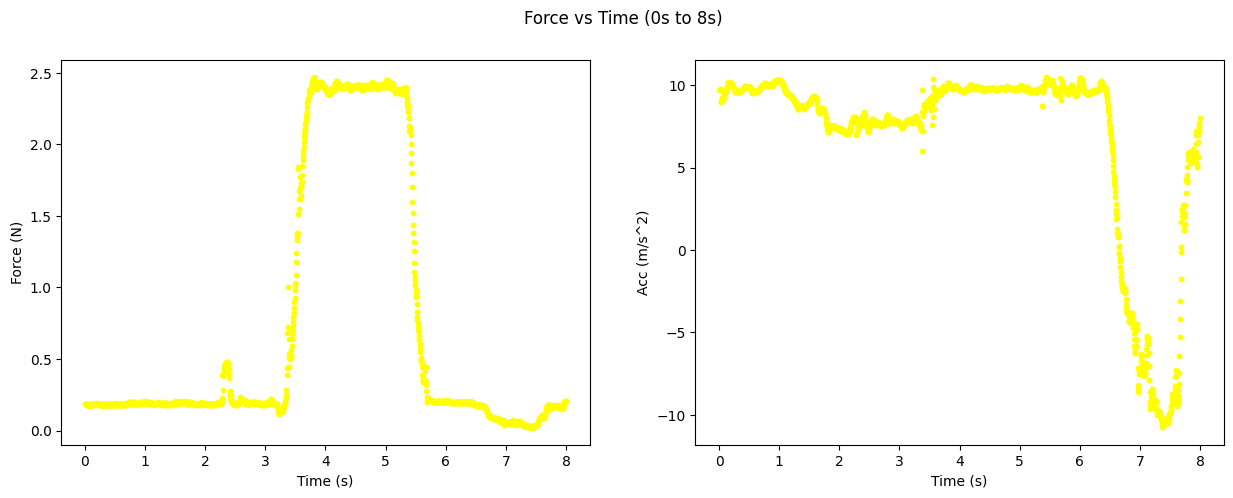

In [7]:
def part0(begin, end):
    data_slice = get_data_slice(data003, begin, end)
    x, y, z = data_slice["time"], 0-data_slice["force"], data_slice["acc"]
    
    
    #create figure
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle("Force vs Time (%ss to %ss)" % (begin, end))

    #plot data points
    ax[0].scatter(x, y, color="yellow", s=10)
    ax[0].set(xlabel="Time (s)", ylabel="Force (N)")

    #plot data points
    ax[1].scatter(x, z, color="yellow", s=10)
    ax[1].set(xlabel="Time (s)", ylabel="Acc (m/s^2)")
part0(0, 8)

def get_force_part0(qb, qe, begin, end):
    slice1 = get_data_slice(data003, begin, end)
    slice2 = get_data_slice(data003, qb, qe)
    f = slice1["force"]
    b = slice2["force"]
    bas = b.mean()
    total = f.mean()
    return bas-total
base = (0, 2)
with_weight = (4,5)
added_force = get_force_part0(*base, *with_weight)
print("Average Force: ", added_force)

## Part 01

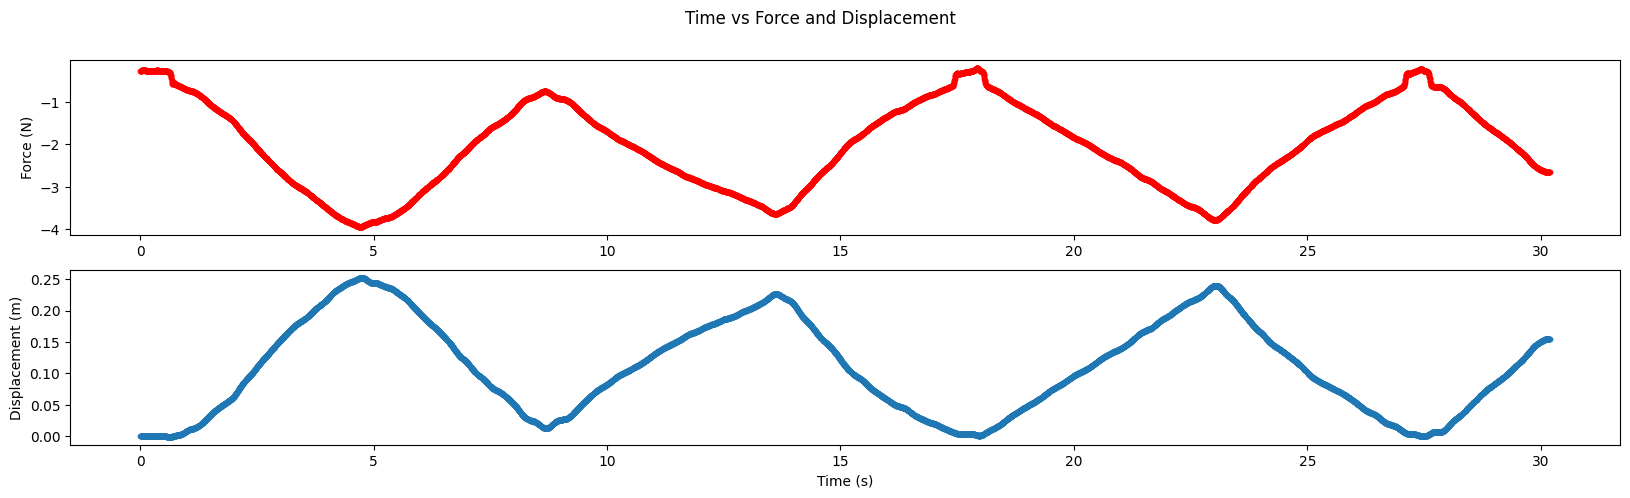

In [8]:
fig1, data01 = plt.subplots(2, figsize=(20,5))
fig1.suptitle("Time vs Force and Displacement")
data01[0].scatter(data012["time"], data012["force"], color="red", s=10)
data01[0].set(ylabel="Force (N)")
data01[1].scatter(data012["time"], data012["displacement"], s=10)
data01[1].set(xlabel="Time (s)", ylabel="Displacement (m)")
plt.show()

### Task: Find Spring Constant

1. select a spring de/extension
2. fit force and distance to find f=-kx
3. find uncertainty a_k
4. compare to accepted value (12 +- 10%)

Slope:  [13.64561655882924, 13.387383503785754, 13.612797314396984, 13.581890508422504, 13.501476821160557]
Spring Constant: 13.5458 ± 0.0036


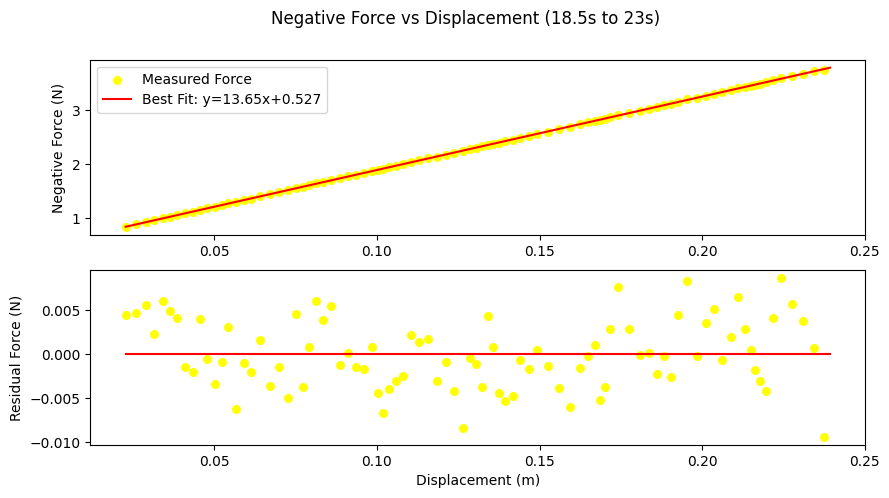

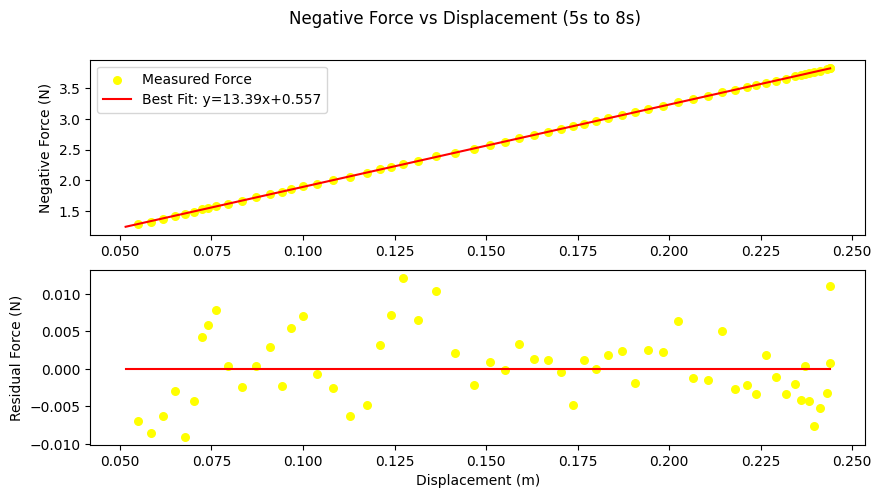

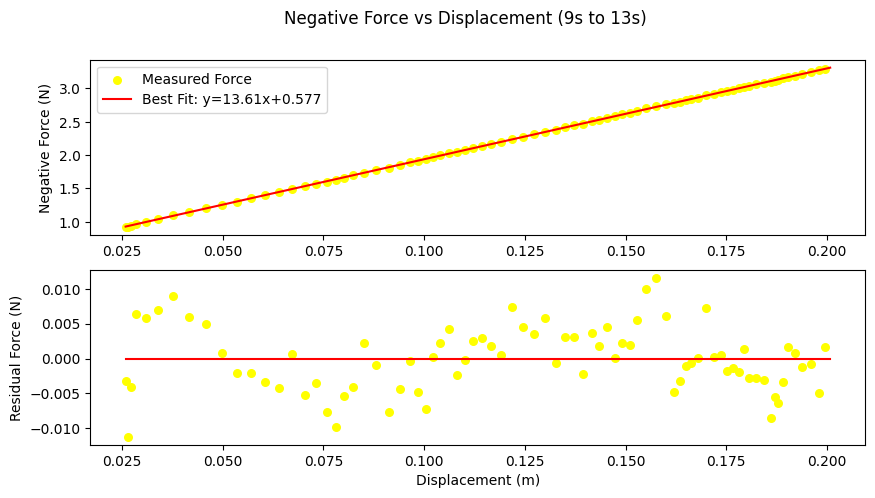

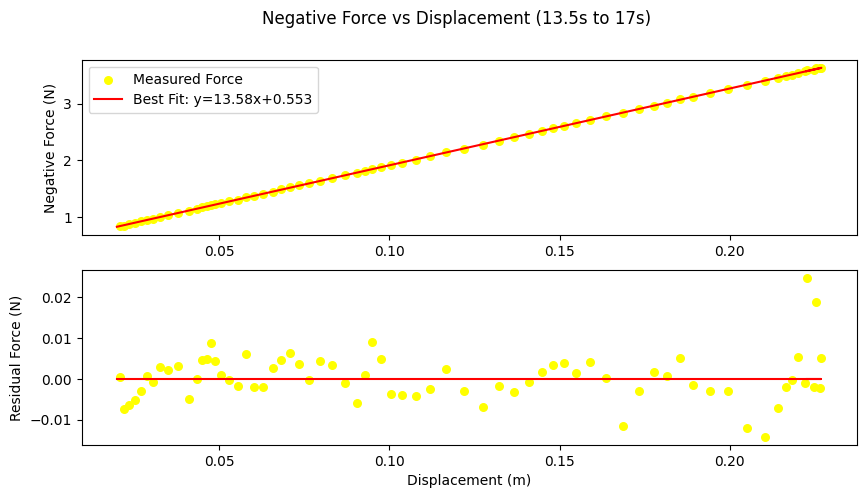

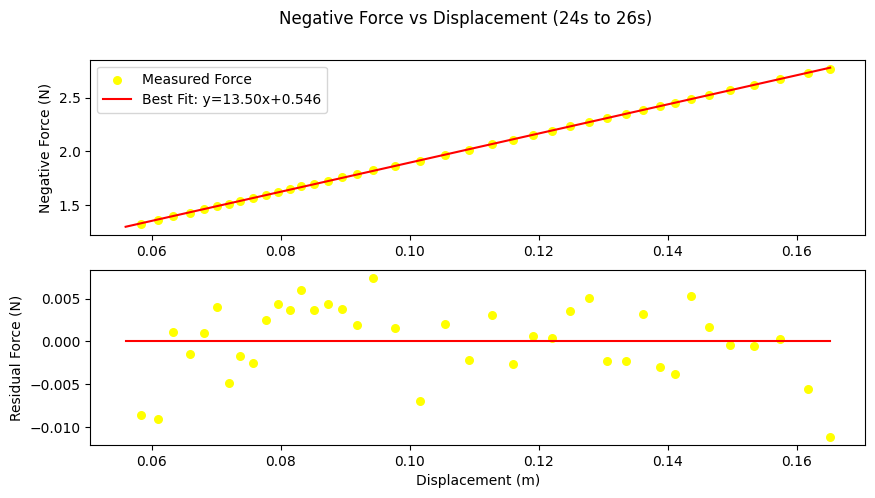

In [36]:
def part1_slice(begin, end):
    val = {}

    #prepare slice
    data_slice = get_data_slice(data012, begin, end)
    x, y = data_slice["displacement"], 0-data_slice["force"]
    fit, V = np.polyfit(x, y, 1, cov=True)

    #calculations
    val["fit"] = fit
    val["std err"] = np.std([x, y], axis=1, ddof=1) / np.sqrt(len(x))
    val["spring err"] = np.sqrt(V[0][0])
    val["spring c err"] = np.sqrt(V[1][1])

    #create figure
    fig, ax = plt.subplots(2, figsize=(10,5))
    fig.suptitle("Negative Force vs Displacement (%ss to %ss)" % (begin, end))

    #plot data points
    ax[0].scatter([d for i, d in enumerate(x) if i % 10 == 0], [d for i, d in enumerate(y) if i % 10 == 0], color="yellow", s=30)
    ax[0].set(ylabel="Negative Force (N)")

    #plot residuals
    ax[1].scatter([d for i, d in enumerate(x) if i % 10 == 0], [d-val["fit"][0]*x[i]-val["fit"][1] for i, d in enumerate(y) if i % 10 == 0], color="yellow", s=30)
    ax[1].set(xlabel="Displacement (m)", ylabel="Residual Force (N)")
    ax[1].plot(x, np.poly1d([0, 0])(x), linestyle='solid', color="red")

    #plot line of best fit
    ax[0].plot(x, np.poly1d(fit)(x), linestyle='solid', color="red")
    ax[0].legend(["Measured Force", "Best Fit: y=%.2fx+%.3f" % (fit[0], fit[1])])

    return val

slices_01 = [
    part1_slice(18.5, 23),
    part1_slice(5, 8),
    part1_slice(9, 13),
    part1_slice(13.5, 17),
    part1_slice(24, 26),
]

print("Slope: ", [s["fit"][0] for s in slices_01])
mean_slope01 = np.mean([s["fit"][0] for s in slices_01])
mean_slope_err01 = np.mean([s["spring err"] for s in slices_01])
print("Spring Constant: %.4f ± %.4f"% (mean_slope01, mean_slope_err01))

## Part 02

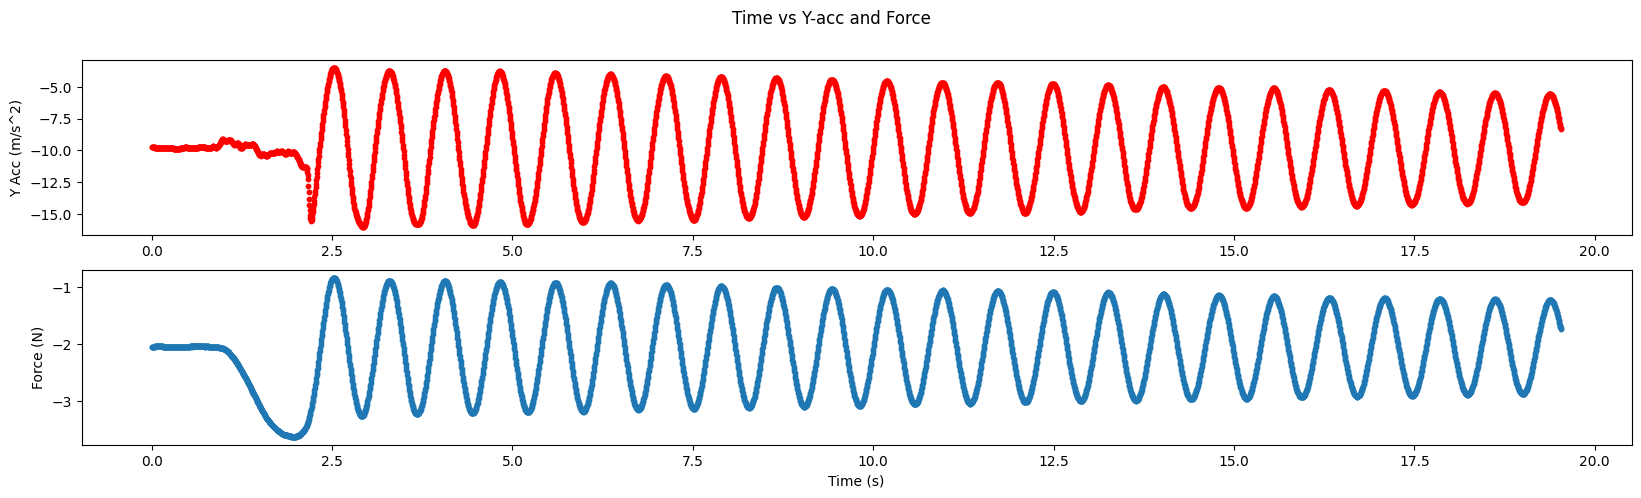

In [10]:
fig2, data2 = plt.subplots(2, figsize=(20,5))
fig2.suptitle("Time vs Y-acc and Force")
data2[0].scatter(dataset2["time"], dataset2["acc"], color="red", s=10)
data2[0].set(ylabel="Y Acc (m/s^2)")
data2[1].scatter(dataset2["time"], dataset2["force"], s=10)
data2[1].set(xlabel="Time (s)", ylabel="Force (N)")
plt.show()

[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Acceleration (m/s^2)')]

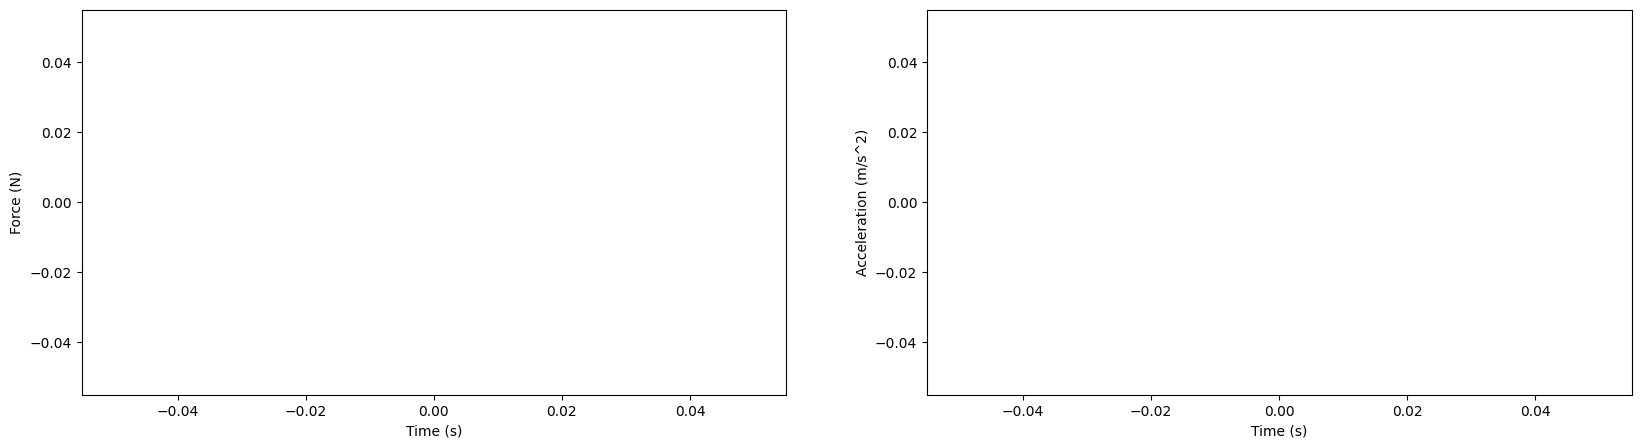

In [11]:
# get the data from 2.5-19 seconds, which is the first de-extension
extension_begin_part_2 = list(dataset2["time"]).index(2.5)
extension_end_part_2 = list(dataset2["time"]).index(19)
slice_part_2 = get_data_slice(dataset2, extension_begin_part_2, extension_end_part_2)

# Load the sliced data
time_slice_part_2 = slice_part_2["time"]
acc_slice_part_2 = slice_part_2["acc"]
force_slice_part_2 = slice_part_2["force"]

#graph it
fig1_part_2, slice_2 = plt.subplots(1, 2, figsize=(20,5))
fig1.suptitle("Time vs Force and Displacement")
slice_2[0].scatter(time_slice_part_2, force_slice_part_2, color="red",s=10)
slice_2[0].set(xlabel="Time (s)", ylabel="Force (N)")
slice_2[1].scatter(time_slice_part_2, acc_slice_part_2, s=10)
slice_2[1].set(xlabel="Time (s)", ylabel="Acceleration (m/s^2)")

#### Part 2 Simple Harmonic Fit

In [12]:
# Inital guesses
guess_A_02_f1 = .1
guess_Wo_02_f1 = 8
guess_phi_02_f1 = 1.5*np.pi

# Fit the sliced data to the model
popt_slice_02_f1, pcov_slice_02_f1 = curve_fit(ayharmonict, time_slice_part_2, acc_slice_part_2, p0=[guess_A_02_f1, guess_Wo_02_f1, guess_phi_02_f1])
A_fit_slice_02_f1, Wo_fit_slice_02_f1, phi_fit_slice_02_f1 = popt_slice_02_f1

# Generate data points for the fitted curve
time_fit_slice_02_f1 = np.linspace(min(time_slice_part_2), max(time_slice_part_2), 1000)
acceleration_fit_slice_02_f1 = ayharmonict(time_fit_slice_02_f1, A_fit_slice_02_f1, Wo_fit_slice_02_f1, phi_fit_slice_02_f1) - 9.8

# Plot the sliced original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_2, acc_slice_part_2, label='Original Data (Slice)')
plt.plot(time_fit_slice_02_f1, acceleration_fit_slice_02_f1, color='red', label='Fitted Curve (Slice)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Fit of Acceleration Data (Slice) to Simple Harmonic Model')
plt.legend()
plt.grid(True)
plt.show()

ValueError: `ydata` must not be empty!

In [ ]:
# Calculate residuals
residuals_slice_02_f1 = acc_slice_part_2 - ayharmonict(time_slice_part_2, A_fit_slice_02_f1, Wo_fit_slice_02_f1, phi_fit_slice_02_f1) + 9.8

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_2, residuals_slice_02_f1, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot Simple Harmonic Fit Part 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Derive the spring constant (k = m * (Wo^2))
k_fit_slice_02_f1 = mass_iolab * Wo_fit_slice_02_f1**2
oscillation_period_02_f1 = 2 * math.pi / Wo_fit_slice_02_f1

print("Fitted Parameters (Slice):")
print("Amplitude (A):", A_fit_slice_02_f1)
print("Angular frequency (Wo):", Wo_fit_slice_02_f1)
print("Phase (phi):", phi_fit_slice_02_f1)
print()
print("Spring constant (k):", k_fit_slice_02_f1)
print("Oscillation Period:", oscillation_period_02_f1)

In [ ]:
# todo need to "Compare the spring constant (manufacturer value= 12±10% N/m) with the value you found in part 1 case, and comment on whether they are consistent or not."

print(k_fit_slice_02_f1 - k_val_approx)

#### Part 2 Damped Fit

In [ ]:
# Initial guesses
guess_A_02_f2 = 1
guess_B_02_f2 = 1
guess_W_02_f2 = 7.5
guess_phi_02_f2 = np.pi

popt_slice_02_f2, pcov_slice_02_f2 = curve_fit(aydampedt, time_slice_part_2, acc_slice_part_2, maxfev= 10000, p0=[guess_A_02_f2, guess_B_02_f2, guess_W_02_f2, guess_phi_02_f2])
A_fit_02_f2, B_fit_02_f2, W_fit_02_f2, phi_fit_02_f2 = popt_slice_02_f2

# Generate data points for the fitted curve
time_fit_slice_02_f2 = np.linspace(min(time_slice_part_2), max(time_slice_part_2), 1000)
acceleration_fit_slice_02_f2= aydampedt(time_fit_slice_02_f2, A_fit_02_f2, B_fit_02_f2, W_fit_02_f2, phi_fit_02_f2) - 9.8

# Plot the sliced original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_2, acc_slice_part_2, label='Original Data (Slice)')
plt.plot(time_fit_slice_02_f2, acceleration_fit_slice_02_f2, color='red', label='Fitted Curve (Slice)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Fit of Acceleration Data (Slice) to Damped Model')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate residuals
residuals_slice_02_f2 = acc_slice_part_2 - aydampedt(time_slice_part_2, A_fit_02_f2, B_fit_02_f2, W_fit_02_f2, phi_fit_02_f2) + 9.8

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_2, residuals_slice_02_f2, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Damped Model Part 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract the fitted parameters
# W = sqrt(k/m) --> k = m*W^2

oscillation_period_02_f2 = 2 * math.pi / W_fit_02_f2
# Calculate k value
k_02_f2 = mass_iolab * W_fit_02_f2**2

print("Fitted Parameters (Slice):")
print("Amplitude (A):", A_fit_02_f2)
print("Angular frequency (W):", W_fit_02_f2)
print("Phase (phi):", phi_fit_02_f2)
print()
print("Spring constant (k):", k_02_f2)
print("Oscillation Period:", oscillation_period_02_f2)
print("Damping Factor Beta (B):", B_fit_02_f2)


In [ ]:
# "Compare the oscillation frequencies from the simple and damped fits."

osc_diff_02 = oscillation_period_02_f2 - oscillation_period_02_f1
print("difference in oscillation frequencies:", osc_diff_02)

print("percent difference in oscillation frequencies values:", (osc_diff_02 / ((oscillation_period_02_f2 / 2)*(oscillation_period_02_f1 / 2)))*100, "%")

## Part 03

In [ ]:
fig3, data3 = plt.subplots(4, figsize=(18,7))
fig3.suptitle("Time vs Measured Values")
data3[0].scatter(dataset3["time"], dataset3["force"], color = 'red', s=10)
data3[0].set(ylabel="Force (N)")
data3[1].scatter(dataset3["time"], dataset3["pos"], color = 'green', s=10)
data3[1].set(ylabel="Position (m)")
data3[2].scatter(dataset3["time"], dataset3["vel"], color = 'orange', s=10)
data3[2].set(ylabel="Velocity (m/s)")
data3[3].scatter(dataset3["time"], dataset3["acc"], s=10)
data3[3].set(xlabel="Time (s)", ylabel="Y Acc (m/s^2)")
plt.show()

In [ ]:
# get the data from 2.5-19 seconds, which is the first de-extension
extension_begin_part_3 = list(dataset3["time"]).index(2.5)
extension_end_part_3 = list(dataset3["time"]).index(19)
slice_part_3 = get_data_slice(dataset3, extension_begin_part_3, extension_end_part_3)

# Load the sliced data
time_slice_part_3 = slice_part_3["time"]
force_slice_part_3 = slice_part_3["force"]
pos_slice_part_3 = slice_part_3["pos"]
vel_slice_part_3 = slice_part_3["vel"]
acc_slice_part_3 = slice_part_3["acc"]

#graph it
fig1_part_3, slice_3 = plt.subplots(1, 2, figsize=(20,5))
slice_3[0].scatter(time_slice_part_3, force_slice_part_3, color="red",s=10)
slice_3[0].set(xlabel="Time (s)", ylabel="Force (N)")
slice_3[1].scatter(time_slice_part_3, acc_slice_part_3, s=10)
slice_3[1].set(xlabel="Time (s)", ylabel="Acceleration (m/s^2)")

#### Part 3 Simple Harmonic Fit

In [ ]:
# Inital guesses
guess_A_03_f1 = .1
guess_Wo_03_f1 = 8
guess_phi_03_f1 = 1.5*np.pi

# Fit the sliced data to the model
popt_slice_03_f1, pcov_slice_03_f1 = curve_fit(ayharmonict, time_slice_part_3, acc_slice_part_3, p0=[guess_A_03_f1, guess_Wo_03_f1, guess_phi_03_f1])
A_fit_slice_03_f1, Wo_fit_slice_03_f1, phi_fit_slice_03_f1 = popt_slice_03_f1

# Generate data points for the fitted curve
time_fit_slice_03_f1 = np.linspace(min(time_slice_part_3), max(time_slice_part_3), 1000)
acceleration_fit_slice_03_f1 = ayharmonict(time_fit_slice_03_f1, A_fit_slice_03_f1, Wo_fit_slice_03_f1, phi_fit_slice_03_f1) - 2

# Plot the sliced original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_3, acc_slice_part_3, label='Original Data (Slice)')
plt.plot(time_fit_slice_03_f1, acceleration_fit_slice_03_f1, color='red', label='Fitted Curve (Slice)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Fit of Acceleration Data (Slice) to Simple Harmonic Model')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate residuals
residuals_slice_03_f1 = acc_slice_part_3 - ayharmonict(time_slice_part_3, A_fit_slice_03_f1, Wo_fit_slice_03_f1, phi_fit_slice_03_f1) + 2

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_3, residuals_slice_03_f1, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Simple Harmonic Model Part 3')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Derive the spring constant (k = m * (Wo^2))
k_fit_slice_03_f1 = mass_iolab * Wo_fit_slice_03_f1**2

oscillation_period_03_f1 = 2 * math.pi / Wo_fit_slice_03_f1

print("Parameters (Slice):")
print("Amplitude (A):", A_fit_slice_03_f1)
print("Angular frequency (Wo):", Wo_fit_slice_03_f1)
print("Phase (phi):", phi_fit_slice_03_f1)
print()
print("Spring constant (k):", k_fit_slice_03_f1)
print("Oscillation Period:", oscillation_period_03_f1)

#### Part 3 Damped Fit

In [ ]:
# Initial guesses
guess_A_03_f2 = .01
guess_B_03_f2 = .01
guess_W_03_f2 = 7.5
guess_phi_03_f2 = np.pi

popt_slice_03_f2, pcov_slice_03_f2 = curve_fit(aydampedt, time_slice_part_3, acc_slice_part_3, maxfev= 1000, p0=[guess_A_03_f2, guess_B_03_f2, guess_W_03_f2, guess_phi_03_f2])
A_fit_03_f2, B_fit_03_f2, W_fit_03_f2, phi_fit_03_f2 = popt_slice_03_f2

# Generate data points for the fitted curve
time_fit_slice_03_f2 = np.linspace(min(time_slice_part_3), max(time_slice_part_3), 1000)
acceleration_fit_slice_03_f2= aydampedt(time_fit_slice_03_f2, A_fit_03_f2, B_fit_03_f2, W_fit_03_f2, phi_fit_03_f2) - 2.05

# Plot the sliced original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_3, acc_slice_part_3, label='Original Data (Slice)')
plt.plot(time_fit_slice_03_f2, acceleration_fit_slice_03_f2, color='red', label='Fitted Curve (Slice)', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Fit of Acceleration Data (Slice) to Damped Model')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate residuals
residuals_slice_03_f2 = acc_slice_part_3 - aydampedt(time_slice_part_3, A_fit_03_f2, B_fit_03_f2, W_fit_03_f2, phi_fit_03_f2) + 2.05

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(time_slice_part_3, residuals_slice_03_f2, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Damped Model Part 3')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Extract the fitted parameters
# W = sqrt(k/m) --> k = m*W^2

oscillation_period_03_f2 = 2 * math.pi / W_fit_03_f2

# Calculate k value
k_03_f2 = mass_iolab * W_fit_03_f2**2

print("Fitted Parameters (Slice):")
print("Amplitude (A):", A_fit_03_f2)
print("Angular frequency (W):", W_fit_03_f2)
print("Phase (phi):", phi_fit_03_f2)
print()
print("Spring constant (k):", k_03_f2)
print("Oscillation Period:", oscillation_period_03_f1)
print("Damping Factor Beta (B):", B_fit_03_f2)

#### Part 3 Constant Friction

In [ ]:
# "Evaluate the peak amplitudes at the turning points for your data. 
# Find the turning points directly from the wheel position, or converting from the force data. 
# Pick whichever sensor is the best, and modify Equation 3 as needed."

In [ ]:
# Identify local maximums and minimums
maxima_indices = argrelextrema(pos_slice_part_3, np.greater)[0]
minima_indices = argrelextrema(pos_slice_part_3, np.less)[0]

maxima_points = [(time_slice_part_3[i], pos_slice_part_3[i]) for i in maxima_indices]
minima_points = [(time_slice_part_3[i], pos_slice_part_3[i]) for i in minima_indices]

# Fit linear equations to the maxima and minima points
max_line_coefficients = np.polyfit([point[0] for point in maxima_points], [point[1] for point in maxima_points], 1)
min_line_coefficients = np.polyfit([point[0] for point in minima_points], [point[1] for point in minima_points], 1)

# Generate lines using the fitted coefficients
max_line = np.poly1d(max_line_coefficients)
min_line = np.poly1d(min_line_coefficients)

# Plot position vs time with maxima and minima points
plt.figure(figsize=(12, 6))
plt.scatter(time_slice_part_3, pos_slice_part_3, label='Position vs Time', color='blue', s=10)  # smaller blue points
plt.scatter(*zip(*maxima_points), color='red', label='Local Maximums')
plt.scatter(*zip(*minima_points), color='green', label='Local Minimums')

# Plot linear lines
plt.plot(time_slice_part_3, max_line(time_slice_part_3), color='red', linestyle='--', label=f'Max Line: {max_line_coefficients[0]:.3f}t + {max_line_coefficients[1]:.3f}')
plt.plot(time_slice_part_3, min_line(time_slice_part_3), color='green', linestyle='--', label=f'Min Line: {min_line_coefficients[0]:.3f}t + {min_line_coefficients[1]:.3f}')

plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position vs Time with Constant Friction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Compute predicted values using the linear fits
max_predicted = max_line([point[0] for point in maxima_points])
min_predicted = min_line([point[0] for point in minima_points])

# Compute residuals
max_residuals = [point[1] - pred for point, pred in zip(maxima_points, max_predicted)]
min_residuals = [point[1] - pred for point, pred in zip(minima_points, min_predicted)]

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter([point[0] for point in maxima_points], max_residuals, color='red', label='Maxima Residuals')
plt.scatter([point[0] for point in minima_points], min_residuals, color='green', label='Minima Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Constant Friction')
plt.legend()
plt.grid(True)
plt.show()